In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [4]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [5]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [6]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [7]:
df_lags_5 = lags(df_final, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,5.71,6.38,7.75,13.00,586.75,581.25,578.66,590.77,594.85,579.95
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,4.62,5.71,6.38,7.75,579.95,586.75,581.25,578.66,590.77,609.86
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,4.62,4.62,5.71,6.38,609.86,579.95,586.75,581.25,578.66,616.17
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,31.75,4.62,4.62,5.71,616.17,609.86,579.95,586.75,581.25,617.56
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,36.88,31.75,4.62,4.62,617.56,616.17,609.86,579.95,586.75,620.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,19.70,19.10,18.50,18.50,409.86,409.15,408.77,408.92,409.00,409.35
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,20.10,19.70,19.10,18.50,409.35,409.86,409.15,408.77,408.92,408.84
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,20.40,20.10,19.70,19.10,408.84,409.35,409.86,409.15,408.77,408.72
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,20.80,20.40,20.10,19.70,408.72,408.84,409.35,409.86,409.15,408.75


In [8]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_5 = pd.DataFrame(scaler.fit_transform(df_lags_5), columns=df_lags_5.columns)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_5.iloc[:,:-1], df_lags_norm_5.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [10]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [11]:
modelLR.coef_

array([[ 1.31547510e-01, -6.27869645e-03, -8.17456616e-02,
        -9.42365799e-03, -3.52914845e-02,  8.30461534e-02,
        -9.97289043e-02, -1.69941667e-02,  3.31617808e-02,
        -1.33500228e-04,  3.10439039e-01, -5.99620658e-01,
        -7.95174378e-01,  9.26461644e-01, -1.20750334e-01,
        -2.80531187e-01,  5.89061769e-01,  7.52343081e-01,
        -9.00753944e-01,  1.16354595e-01,  1.13280894e+00,
        -2.93495645e-02, -8.81931448e-03,  4.17943974e-03,
        -1.03604964e-01]])

In [12]:
modelLR.intercept_

array([0.0016442])

In [13]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

array([[0.11537059],
       [0.13520809],
       [0.13939314],
       ...,
       [0.00180401],
       [0.00182391],
       [0.00236777]])

In [14]:
# make predictions
trainPredict = modelLR.predict(X_train)
testPredict = modelLR.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.to_numpy())
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.to_numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.62 RMSE
Test Score: 10.03 RMSE


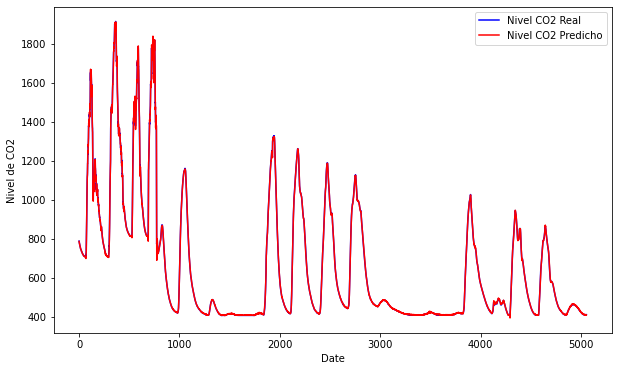

In [15]:
plt.figure(figsize=(10,6))
plt.plot(y_test, color='blue', label='Nivel CO2 Real')
plt.plot(testPredict , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

In [16]:
df_lags_10 = lags(df_final, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,27.34,...,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,594.85,623.75
1,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,...,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,617.60
2,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,...,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,610.68
3,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,...,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,614.24
4,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,...,610.68,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,614.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.69,409.35
16841,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.84
16842,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,408.72
16843,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.84,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,408.75


In [28]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_10 = pd.DataFrame(scaler.fit_transform(df_lags_10), columns=df_lags_10.columns)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_10.iloc[:,:-1], df_lags_norm_10.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [19]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [20]:
modelLR.coef_

array([[ 0.12582064, -0.00158447, -0.09490568, -0.0147944 ,  0.02346009,
        -0.00570566, -0.05653884,  0.02484114,  0.01046011, -0.0127993 ,
         0.09043518, -0.09854649, -0.01832968,  0.03549905,  0.00210183,
        -0.05968819,  0.03385105,  0.0203004 , -0.04604631,  0.03969555,
         0.40539311, -0.91024234, -0.85830576,  1.03122449, -0.25942131,
        -0.11511318,  0.61815303,  0.17080475, -0.09627733, -0.38810285,
        -0.38255486,  0.89986824,  0.82293127, -1.00396336,  0.24701705,
         0.13433581, -0.66814808, -0.14535522,  0.12719773,  0.37186513,
         1.12751929, -0.03145474, -0.01026204,  0.00530765, -0.08612519,
         0.02310915, -0.01940202, -0.02781952,  0.01813754, -0.00448614]])

In [12]:
modelLR.intercept_

array([0.00170168])

In [36]:
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPred = []
    preds = []

    testPredict = modelLR.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(10):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        testScore = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        testPred.append(testScore)
        preds.append(testPredict_transform)
        print('Test Score: %.2f RMSE' % (testScore))
        
    return testPred, preds
    

In [37]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_10['co2'].to_numpy().reshape(-1, 1))

testPred_10, preds_10 = recursiveStepsAhead(X_test, y_test, 10, scaler, modelLR)

Test Score: 11.15 RMSE
Test Score: 14.45 RMSE
Test Score: 18.72 RMSE
Test Score: 23.22 RMSE
Test Score: 27.88 RMSE
Test Score: 32.58 RMSE
Test Score: 37.28 RMSE
Test Score: 42.01 RMSE
Test Score: 46.73 RMSE
Test Score: 51.44 RMSE


In [143]:
prueba_X_test = X_test.copy()
testPred = []
preds = []

testPredict = modelLR.predict(prueba_X_test)

for p in range(10):
    prueba_X_test = pd.concat( [prueba_X_test.iloc[:,:40], prueba_X_test.iloc[:,40:].shift(1, axis = 1) ], axis=1)
    prueba_X_test['Lag_co2_' + str(1)] = testPredict
    
    testPredict = modelLR.predict(prueba_X_test)
        
    # invert predictions
    testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
    y_test_transform = scaler.inverse_transform(y_test.to_numpy())
    

    # calculate root mean squared error
    testScore = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
    testPred.append(testScore)
    preds.append(testPredict_transform)
    print('Test Score: %.2f RMSE' % (testScore))
    
    

Test Score: 11.15 RMSE
Test Score: 14.45 RMSE
Test Score: 18.72 RMSE
Test Score: 23.22 RMSE
Test Score: 27.88 RMSE
Test Score: 32.58 RMSE
Test Score: 37.28 RMSE
Test Score: 42.01 RMSE
Test Score: 46.73 RMSE
Test Score: 51.44 RMSE


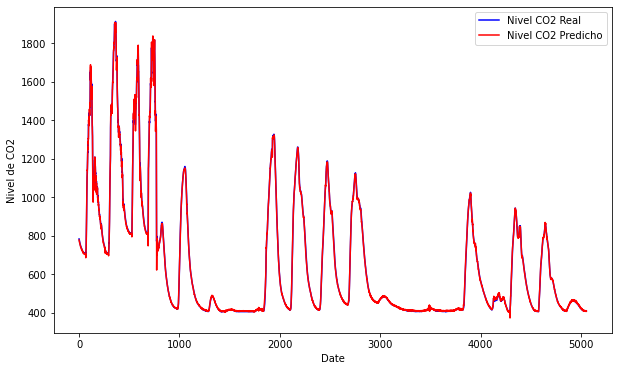

In [147]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transform, color='blue', label='Nivel CO2 Real')
plt.plot(preds[0] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

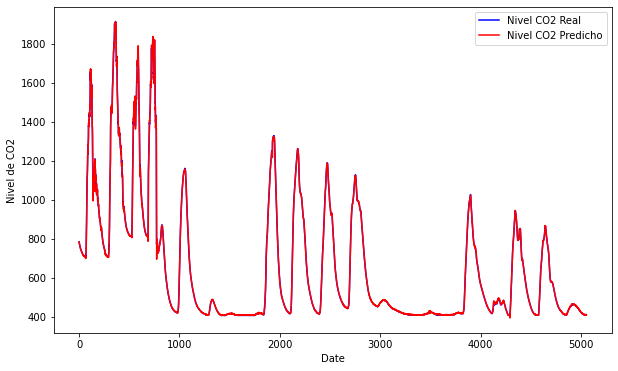

In [59]:
plt.figure(figsize=(10,6))
plt.plot(y_test, color='blue', label='Nivel CO2 Real')
plt.plot(testPredict , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()